# Fashion MINST

## Imports

In [28]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

## Data analysis

In [29]:
DATA_PATH = './data'
trainset_raw = torchvision.datasets.FashionMNIST(DATA_PATH, download=True)
testset_raw = torchvision.datasets.FashionMNIST(DATA_PATH, download=True, train=False)

In [30]:
ex_img, ex_category = trainset_raw[256]
type(ex_img), ex_img.size, ex_img.mode

(PIL.Image.Image, (28, 28), 'L')

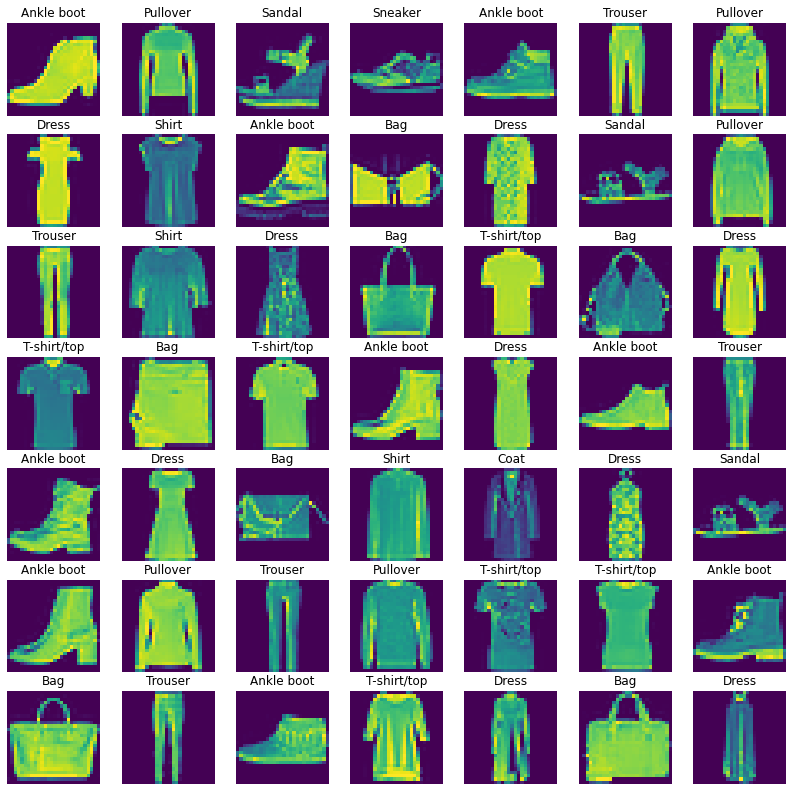

In [31]:
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

rows = 7
columns = 7
fig, axs = plt.subplots(rows, columns, figsize=(2 * columns, 2 * rows))
for row in range(rows):
    for column in range(columns):
        img, category = trainset_raw.__getitem__(np.random.randint(10000))
        ax = axs[row, column]
        ax.imshow(np.asarray(img), interpolation='none')
        ax.set_title(classes[category])
        ax.axis('off')

## Model

In [37]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1,
                               out_channels=32,
                               kernel_size=3,
                               padding=1)
        self.conv2 = nn.Conv2d(in_channels=32,
                               out_channels=64,
                               kernel_size=3,
                               padding=1)
        self.conv3 = nn.Conv2d(in_channels=64,
                               out_channels=128,
                               kernel_size=3,
                               padding=1)
        self.conv4 = nn.Conv2d(in_channels=128,
                               out_channels=80,
                               kernel_size=3,
                               padding=1)
        self.conv5 = nn.Conv2d(in_channels=80,
                               out_channels=40,
                               kernel_size=3,
                               padding=1)

        self.pool_small = nn.MaxPool2d((2, 2))

        self.fc1 = nn.Linear(360, 200)
        self.fc2 = nn.Linear(200, 80)
        self.fc3 = nn.Linear(80, 10)

    def forward(self, x):
        # With pooling.
        x = F.relu(self.conv1(x))
        x = self.pool_small(x)
        x = F.relu(self.conv2(x))
        x = self.pool_small(x)
        x = F.relu(self.conv3(x))
        x = self.pool_small(x)

        # Without pooling.
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = x.view(x.shape[0], self.num_flat_features(x))

        x = F.relu(F.dropout(self.fc1(x), p=0.6))
        x = F.relu(F.dropout(self.fc2(x), p=0.2))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

# Training Helper

In [38]:
class TrainingHelper:

    tracked_values = ['epoch_loss_train',
                      'epoch_acc_train',
                      'epoch_loss_test',
                      'epoch_acc_test',
                      'batch_loss_train']
    CHECKPOINTS_PATH = 'checkpoints/'

    def __init__(self, trainset_len, trainloader, testset_len, testloader, device, name):
        self.trainset_len = trainset_len
        self.trainloader = trainloader
        self.testset_len = testset_len
        self.testloader = testloader
        self.device = device
        self.name = name

    def train_and_evaluate_model(self,
                                 model,
                                 criterion,
                                 optimizer,
                                 num_epochs=10,
                                 save_every_nth_batch_loss=50):
        """Train and evaluate the classification model."""
        run_hist = {key: [] for key in self.tracked_values}
        try:
            for epoch in range(num_epochs):
                if epoch % 10 == 0:
                    print('Epoch {}/{}'.format(epoch+1, num_epochs))
                    print('-' * 10)

                # training phase
                model.train()

                running_loss_train = 0.0
                running_corrects_train = 0

                i = 0
                for inputs, labels in self.trainloader:
                    inputs = inputs.to(self.device)
                    labels = labels.to(self.device)

                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                    _, preds = torch.max(outputs, 1)
                    running_loss_train += loss.detach() * inputs.size(0)
                    running_corrects_train += torch.sum(preds == labels.data)

                    if i % save_every_nth_batch_loss == 0:
                        run_hist['batch_loss_train'].append(loss.item())
                    i += 1

                epoch_loss_train = running_loss_train / self.trainset_len
                epoch_acc_train = running_corrects_train.float() / self.trainset_len
                
                if epoch % 10 == 0:
                    print('train loss: {:.4f}, train acc: {:.4f}'.\
                    format(epoch_loss_train.item(),
                           epoch_acc_train.item()))

                run_hist['epoch_loss_train'].append(epoch_loss_train.item())
                run_hist['epoch_acc_train'].append(epoch_acc_train.item())

                # evaluating phase
                model.eval()

                running_loss_test = 0.0
                running_corrects_test = 0

                for inputs, labels in self.testloader:
                    inputs = inputs.to(self.device)
                    labels = labels.to(self.device)

                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)
                    running_loss_test += loss.detach() * inputs.size(0)
                    running_corrects_test += torch.sum(preds == labels.data)

                epoch_loss_test = running_loss_test / self.testset_len
                epoch_acc_test = running_corrects_test.float() / self.testset_len
                
                if epoch % 10 == 0:
                    print('test loss: {:.4f}, test acc: {:.4f}\n'.\
                    format(epoch_loss_test.item(),
                           epoch_acc_test.item()))

                run_hist['epoch_loss_test'].append(epoch_loss_test.item())
                run_hist['epoch_acc_test'].append(epoch_acc_test.item())

        except KeyboardInterrupt:
            pass
        return run_hist

## Augmentation

We'll train 3 ConvNet models on 3 different datasets.
* raw - exactly the same as training data
* flip - randomly apply horizontal flip
* rotate - randomly apply rotation

## Ensembling

1. Calculate prediction vector for every model.
2. Apply softmax on every vector.
3. Calculate average.
4. Pick class with biggest value.

## Create datasets

In [39]:
transform_raw = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ])
transform_flip = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
    torchvision.transforms.RandomHorizontalFlip()
])
transform_rotate = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
    torchvision.transforms.RandomRotation(10)
])

In [40]:
def loader_train(train_set):
    return torch.utils.data.DataLoader(train_set,
                                       batch_size=100,
                                       shuffle=True,
                                       num_workers=2)
def loader_test(test_set):
        return torch.utils.data.DataLoader(test_set,
                                           batch_size=100,
                                           shuffle=False,
                                           num_workers=1)
def split(train_set):
        if len(train_set) != 60000:
            raise ValueError

        return torch.utils.data.random_split(train_set,
                                             [50000, 10000],
                                             generator=torch.Generator().manual_seed(1))


train_set_raw = torchvision.datasets.FashionMNIST(root=DATA_PATH,
                                                  train=True,
                                                  download=True,
                                                  transform=transform_raw)
train_set_flip = torchvision.datasets.FashionMNIST(root=DATA_PATH,
                                                   train=True,
                                                   download=True,
                                                   transform=transform_flip)
train_set_rotate = torchvision.datasets.FashionMNIST(root=DATA_PATH,
                                                     train=True,
                                                     download=True,
                                                     transform=transform_rotate)
train_set = {
    'raw': train_set_raw,
    'flip': train_set_flip,
    'rotate': train_set_rotate
}


t_raw_set, validate_set = split(train_set['raw'])
t_flip_set, _ = split(train_set['flip'])
t_rotate_set, _ = split(train_set['rotate'])

t_set = {
    'raw': t_raw_set,
    'flip': t_flip_set,
    'rotate': t_rotate_set
}

test_set_raw = torchvision.datasets.FashionMNIST(root=DATA_PATH,
                                                 train=False,
                                                 download=True,
                                                 transform=transform_raw)

## Training

In [41]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

models = {
    'raw': ConvNet().to(device),
    'flip': ConvNet().to(device),
    'rotate': ConvNet().to(device)
}

hist = {}

for k in models:
    m = models[k]
    t = t_set[k]
    training = TrainingHelper(len(t), loader_train(t), len(validate_set), loader_test(validate_set), device, k)
    hist[k] = training.train_and_evaluate_model(m, nn.CrossEntropyLoss(), optim.Adam(m.parameters()), num_epochs=50)

Epoch 1/50
----------
train loss: 0.8235, train acc: 0.6883
test loss: 0.5377, test acc: 0.8079

Epoch 11/50
----------
train loss: 0.1670, train acc: 0.9412
test loss: 0.2741, test acc: 0.9051

Epoch 21/50
----------
train loss: 0.0759, train acc: 0.9740
test loss: 0.3755, test acc: 0.9117

Epoch 31/50
----------
train loss: 0.0470, train acc: 0.9847
test loss: 0.5032, test acc: 0.9144

Epoch 41/50
----------
train loss: 0.0327, train acc: 0.9897
test loss: 0.5635, test acc: 0.9168

Epoch 1/50
----------
train loss: 0.8768, train acc: 0.6685
test loss: 0.5558, test acc: 0.7979

Epoch 11/50
----------
train loss: 0.1988, train acc: 0.9303
test loss: 0.2666, test acc: 0.9076

Epoch 21/50
----------
train loss: 0.1274, train acc: 0.9553
test loss: 0.2956, test acc: 0.9166

Epoch 31/50
----------
train loss: 0.0834, train acc: 0.9708
test loss: 0.3079, test acc: 0.9207

Epoch 41/50
----------
train loss: 0.0633, train acc: 0.9787
test loss: 0.3996, test acc: 0.9176

Epoch 1/50
----------


## Training results

In [44]:
def plot_training(run_hist):
    """Plot the training history of the classification model."""
    fig, ax = plt.subplots(1, 2, figsize=(20, 6), sharex=True)
    x = np.arange(len(run_hist["epoch_loss_train"])) + 1
    ax[0].plot(x, run_hist["epoch_loss_train"], 'b', marker='.', label="epoch train loss")
    ax[0].plot(x, run_hist["epoch_loss_test"], 'r', marker='.', label="epoch test loss")
    ax[0].legend()
    ax[1].plot(x, run_hist["epoch_acc_train"], 'b', marker='.', label="epoch train accuracy")
    ax[1].plot(x, run_hist["epoch_acc_test"], 'r', marker='.', label="epoch test accuracy")
    ax[1].legend()

    fig, ax = plt.subplots(1, 1, figsize=(20, 6), sharex=True)
    x = np.arange(len(run_hist["batch_loss_train"])) + 1
    ax.plot(x, run_hist["batch_loss_train"], 'b', marker='.', label="batch train loss")
    ax.legend()

def save(self, model, name):
    torch.save(model, os.path.join('./checkpoints/', name))

def load(self, name):
    model = torch.load(os.path.join('./checkpoints/', name))
    model.eval()
    return model

## Raw

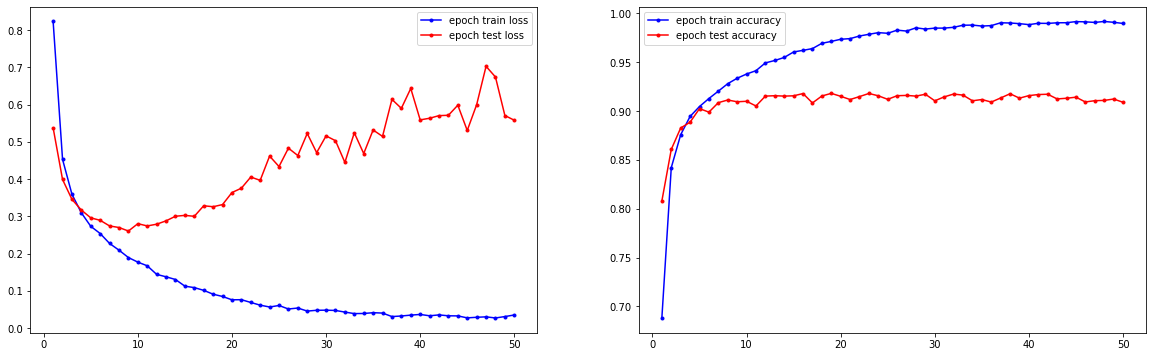

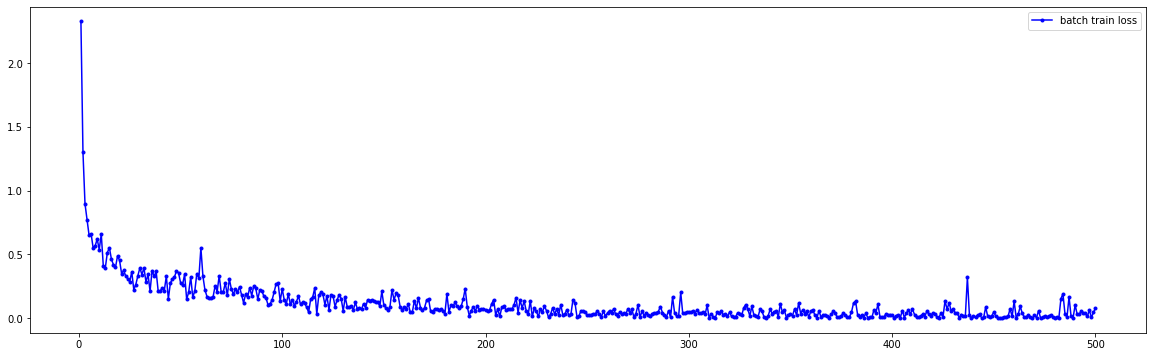

In [45]:
plot_training(hist['raw'])

## Flip

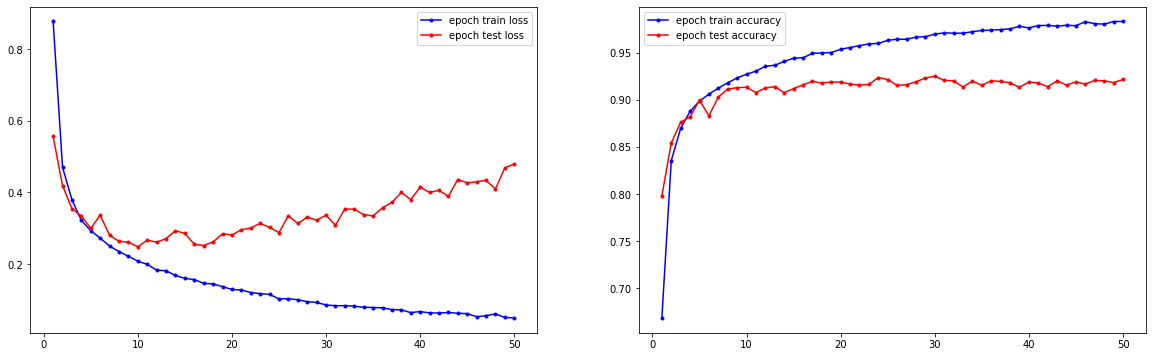

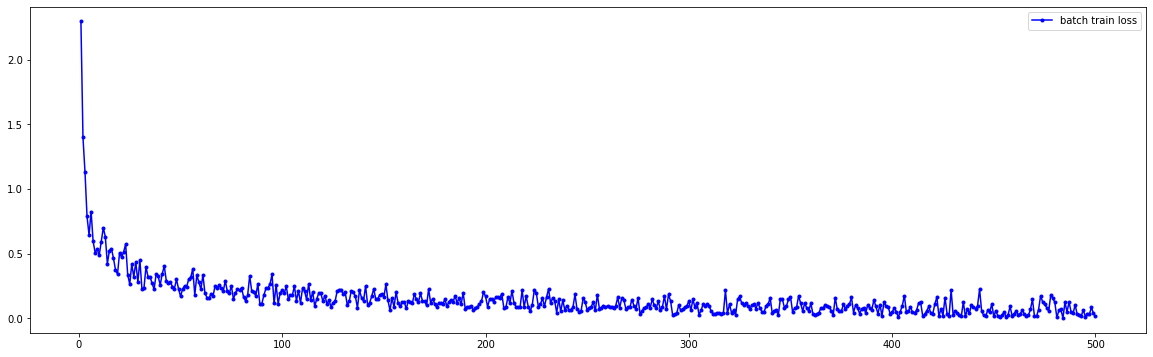

In [46]:
plot_training(hist['flip'])

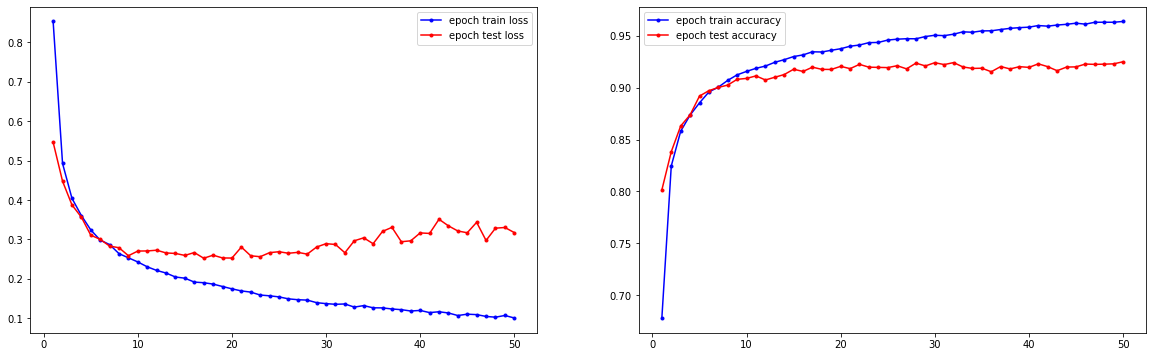

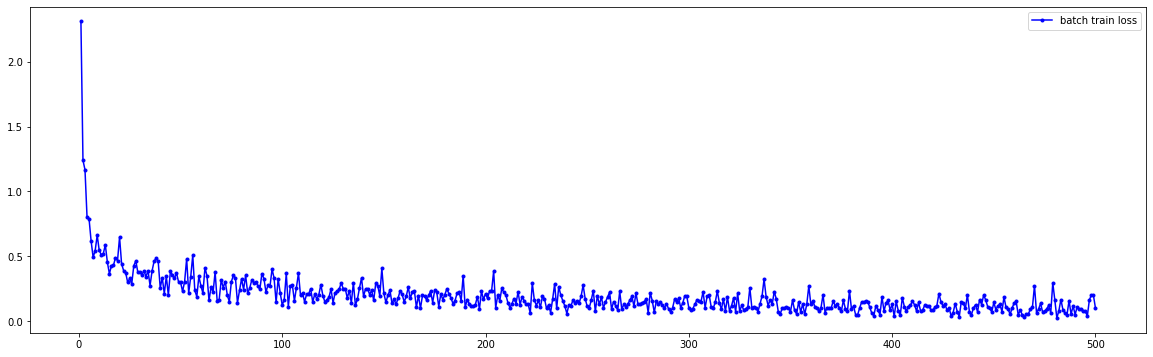

In [47]:
plot_training(hist['rotate'])

## Ensemble

In [54]:
criterion = nn.CrossEntropyLoss()
running_loss_test = 0.0
running_corrects_test = 0.0
predictions = []

for inputs, labels in loader_test(validate_set):
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = []
    for model in models.values():
        output = model(inputs)
        output = F.softmax(output, dim=1)
        outputs.append(output)

    output = (outputs[0] + outputs[1] + outputs[2]) / 3
    loss = criterion(output, labels)

    _, preds = torch.max(output, 1)
    running_loss_test += loss.detach() * inputs.size(0)
    running_corrects_test += torch.sum(preds == labels.data)
    predictions += list(preds.cpu().detach().numpy())

running_corrects_test.float() / len(validate_set)

tensor(0.9339, device='cuda:0')

## Train on all data

In [ ]:
models = {
    'raw': ConvNet().to(device),
    'flip': ConvNet().to(device),
    'rotate': ConvNet().to(device)
}

for k in models:
    m = models[k]
    t = train_set[k]
    training = TrainingHelper(len(t), loader_train(t), len(validate_set), loader_test(validate_set), device, k)
    training.train_and_evaluate_model(m, nn.CrossEntropyLoss(), optim.Adam(m.parameters()), num_epochs=50)

## Ensemble

In [ ]:
for inputs, _ in loader_test(validate_set):
    inputs = inputs.to(device)

    outputs = []
    for model in models.values():
        output = model(inputs)
        output = F.softmax(output, dim=1)
        outputs.append(output)

    output = (outputs[0] + outputs[1] + outputs[2]) / 3
    _, preds = torch.max(output, 1)
    predictions += list(preds.cpu().detach().numpy())

predictions = np.array(predictions)

## Submission

In [ ]:
submission = pd.DataFrame()
submission['Id'] = np.arange(len(test_set))
submission['Class'] = predictions
submission.to_csv('submission.csv', index=False)